# NCS
## Loading basic libraries and testing the virtual environment

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import sklearn
import seaborn as sns
#import tensorflow as tf
#import tensorflow_datasets as tfds
from sklearn.svm import  SVC
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC

In [3]:
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 0.24.2.


In [4]:
df = pd.read_csv("../dataset/NC_policing.csv")


In [5]:
print (df.head())
print (df.dtypes)

  state   stop_date driver_gender  driver_age driver_race_raw driver_race  \
0    NC  2000-07-31             M        23.0             W N       White   
1    NC  2000-07-31             F        29.0             W N       White   
2    NC  2000-07-31             F        49.0             B N       Black   
3    NC  2000-07-31             M        29.0             B N       Black   
4    NC  2000-07-31             M        24.0             U H    Hispanic   

  violation          search_type  contraband_found stop_outcome  \
0  Speeding  No Search Conducted             False       Arrest   
1  Speeding  No Search Conducted             False       Arrest   
2  Speeding  No Search Conducted             False       Arrest   
3  Speeding  No Search Conducted             False       Arrest   
4  Speeding  No Search Conducted             False       Arrest   

          search_basis  officer_id drugs_related_stop district  
0  No Search Conducted       10606                NaN       E3  
1  N

Text(0.5, 1.0, 'Correlation between features')

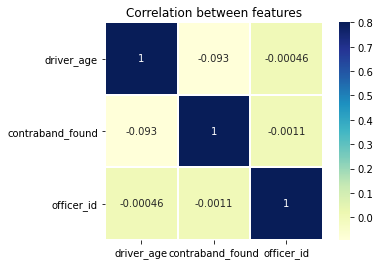

In [6]:
corr = df.corr()
plt.figure(figsize=[11,11])
sns.heatmap(corr,vmax=.8, linewidths=0.01,
           square=True,annot=True,cmap='YlGnBu',linecolor="white")
plt.title('Correlation between features')

In [7]:
y= df['stop_outcome']
X= df.drop(columns=['state','driver_race_raw','stop_date'])
# drop the drugs _ related_stop 


In [8]:
df.isna().sum()
X= df.drop(columns=['drugs_related_stop'])

In [9]:
df["driver_age"].fillna(df["driver_age"].mean(), inplace = True) 

In [10]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
col= ["driver_gender","driver_race_raw","driver_race","violation","search_type","contraband_found",
      "stop_outcome","search_basis","officer_id","district","drugs_related_stop"
]
df_encoded = df
df_encoded[col]=df_encoded[col].apply(lambda col: le.fit_transform(col))
df_encoded.head()

,state,stop_date,driver_gender,driver_age,driver_race_raw,driver_race,violation,search_type,contraband_found,stop_outcome,search_basis,officer_id,drugs_related_stop,district
0,NC,2000-07-31,1,23.0,9,4,6,2,0,0,18,722,1,34
1,NC,2000-07-31,0,29.0,9,4,6,2,0,0,18,722,1,34
2,NC,2000-07-31,0,49.0,3,1,6,2,0,0,18,722,1,34
3,NC,2000-07-31,1,29.0,3,1,6,2,0,0,18,722,1,34
4,NC,2000-07-31,1,24.0,6,2,6,2,0,0,18,722,1,34


In [11]:
y= df_encoded['stop_outcome']
X= df_encoded.drop(columns=['state','driver_race_raw','stop_date'])

In [12]:
X.head()

,driver_gender,driver_age,driver_race,violation,search_type,contraband_found,stop_outcome,search_basis,officer_id,drugs_related_stop,district
0,1,23.0,4,6,2,0,0,18,722,1,34
1,0,29.0,4,6,2,0,0,18,722,1,34
2,0,49.0,1,6,2,0,0,18,722,1,34
3,1,29.0,1,6,2,0,0,18,722,1,34
4,1,24.0,2,6,2,0,0,18,722,1,34


In [13]:
df_encoded.isna().sum()
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 402087 entries, 0 to 402086
Data columns (total 14 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   state               402087 non-null  object 
 1   stop_date           402087 non-null  object 
 2   driver_gender       402087 non-null  int32  
 3   driver_age          402087 non-null  float64
 4   driver_race_raw     402087 non-null  int32  
 5   driver_race         402087 non-null  int32  
 6   violation           402087 non-null  int32  
 7   search_type         402087 non-null  int32  
 8   contraband_found    402087 non-null  int64  
 9   stop_outcome        402087 non-null  int32  
 10  search_basis        402087 non-null  int32  
 11  officer_id          402087 non-null  int64  
 12  drugs_related_stop  402087 non-null  int32  
 13  district            402087 non-null  int32  
dtypes: float64(1), int32(9), int64(2), object(2)
memory usage: 29.1+ MB
None


Model

In [14]:
from sklearn.model_selection import train_test_split
X= X.astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3,random_state=200) 
X.dtypes

driver_gender         int32
driver_age            int32
driver_race           int32
violation             int32
search_type           int32
contraband_found      int32
stop_outcome          int32
search_basis          int32
officer_id            int32
drugs_related_stop    int32
district              int32
dtype: object

In [15]:
# testing with knn this is not a classifier 
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=15)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)


<Figure size 432x288 with 0 Axes>

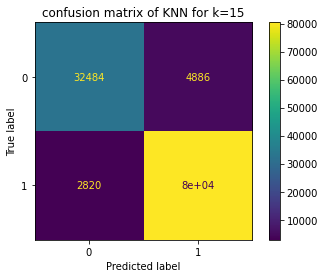

In [16]:
from sklearn.metrics import plot_confusion_matrix
# Plot the confusion matrix for the test set for the KNN classifier
plt.figure()
plot_confusion_matrix(knn, X_test, y_test)
plt.title('confusion matrix of KNN for k=15')
plt.show()


In [17]:
#first classifier without pca (no need for compression)
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
num_splits = 5
#kfold = KFold(n_splits=num_splits, random_state=10, shuffle=True)

max_comp = X.shape[1]
param_grid = { 'n_neighbors':[5,10,15]}

#pipeline = Pipeline(steps=[('scaler',StandardScaler()), ('estimator', KNeighborsClassifier())])
search = GridSearchCV(KNeighborsClassifier(),param_grid, n_jobs=-1, cv=5, scoring='accuracy', return_train_score=True)
search.fit(X_train,y_train)

In [ ]:
print("accuracy" ,search.best_score_)
print(search.best_params_)

accuracy 0.9440879698713849
{'n_neighbors': 5}


In [ ]:
best_estimator = search.best_estimator_
y_pred = best_estimator.predict(X_test)

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

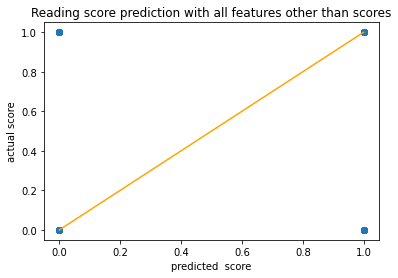

In [ ]:
# doesn't really make sense
fig = plt.figure()
plt.scatter(y_pred,y_test)
plt.title ("Reading score prediction with all features other than scores")
plt.xlabel("predicted  score")
plt.ylabel("actual score")
plt.plot([y_pred.min(),y_pred.max()],[y_test.min(),y_test.max()],color='orange')
plt.show()

<ipython-input-19-1a236fa28ba0>:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax.plot([0, 1], [0, 1], 'k--',color='blue')


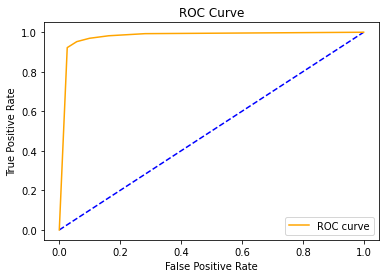

In [ ]:
# Plot roc knn
from sklearn.metrics import roc_curve
y_pred_prob = search.best_estimator_.predict_proba(X_test)[:,1]
fprc, tprc, thresholds = roc_curve(y_test, y_pred_prob)
fig = plt.figure()
ax = fig.add_subplot()
ax.plot([0, 1], [0, 1], 'k--',color='blue')
ax.plot(fprc, tprc,label='ROC curve',color='orange')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc=4)
plt.show()

Metrics functions

In [ ]:

def separation(tn, fp, fn, tp):
   
    Y_0 = tn / (tn + fn)
    Y_1 = tp / (tp + fp)
  
    return Y_1, Y_0

def sufficiency(tn, fp, fn, tp):
    R_1 = tp / (tp + fn)
    R_0 = fp / (fp + tn)
    return R_1, R_0
# switched tp and tn 
def independence (tp,tn,fn,fp ):
    return (tp + fp) / (tn + fp + fn + tp)



In [ ]:
sep = separation(tn,fp,fn,tp)
suf = sufficiency(tn, fp, fn, tp)
ind = independence (tp,tn,fn,fp )

In [ ]:
print (sep)
print(suf)
print(ind)

(0.9559779712204655, 0.9298463748894783)
(0.9695040657242033, 0.09946481134599947)
0.6999676689298415


In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
#pipeline = Pipeline(steps=[('scaler',StandardScaler()),('pca', PCA()), ('estimator', LinearRegression())])

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn import decomposition
std_slc = StandardScaler()
logistic_Reg = LogisticRegression()
pca = decomposition.PCA()
pipe = Pipeline(steps=[('std_slc', std_slc),
                           ('logistic_Reg', logistic_Reg)])
#n_components = list(range(1,X.shape[1]))
C = np.logspace(-4, 4, 2)
parameters = dict(#pca__n_components=n_components,
                  logistic_Reg__C=C)
search_lin = GridSearchCV(pipe,parameters, cv=5, scoring='accuracy', return_train_score=True)
search_lin.fit(X_train,y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('std_slc', StandardScaler()),
                                       ('logistic_Reg', LogisticRegression())]),
             param_grid={'logistic_Reg__C': array([1.e-04, 1.e+04])},
             return_train_score=True, scoring='accuracy')

In [ ]:
print(search_lin.best_params_)
print(search_lin.best_score_)

{'logistic_Reg__C': 10000.0}
1.0


In [ ]:
best_estimator = search.best_estimator_
y_pred_lin = search_lin.best_estimator_.predict(X_test)

[[37370     0]
 [    0 83257]]


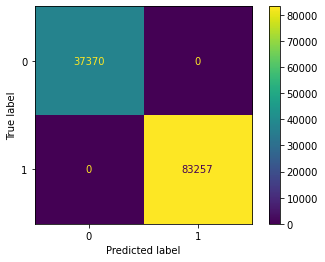

In [ ]:
cm = confusion_matrix(y_test, y_pred_lin)
tn, fp, fn, tp = cm.ravel()
plot_confusion_matrix(search_lin, X_test, y_test)  
print(cm)

<ipython-input-29-10a9d47d2815>:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax.plot([0, 1], [0, 1], 'k--',color='blue')


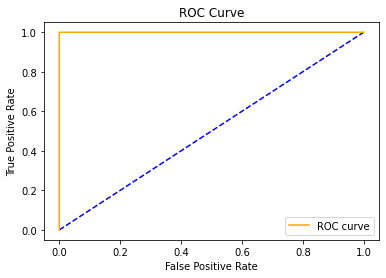

In [ ]:
# Plot
from sklearn.metrics import roc_curve
y_pred_prob = search_lin.best_estimator_.predict_proba(X_test)[:,1]
fp, tp, thresholds = roc_curve(y_test, y_pred_prob)
fig = plt.figure()
ax = fig.add_subplot()
ax.plot([0, 1], [0, 1], 'k--',color='blue')
ax.plot(fp, tp,label='ROC curve',color='orange')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc=4)
plt.show()

In [ ]:
from sklearn.dummy import DummyClassifier
s ='most_frequent'

test_scores = []
dclf = DummyClassifier(strategy = s, random_state = 0)
dclf.fit(X_train, y_train)
score = dclf.score(X_test, y_test)
test_scores.append(score)
print (test_scores)

[0.6902020277384002]


In [ ]:
df.loc[df['stop_outcome']==0,'stop_outcome'].count() # to check for the corecctness of the dummy classifier

123814

In [ ]:
# calculate it manually 

In [ ]:
X_train_fair = X_train.drop('driver_race',axis=1)
X_test_fair = X_test.drop('driver_race', axis=1)

In [ ]:
X_train_fair.head()


,driver_gender,driver_age,violation,search_type,contraband_found,stop_outcome,search_basis,officer_id,drugs_related_stop,district
126852,1,39,2,2,0,1,18,2224,1,55
393530,1,42,2,2,0,1,18,1942,1,31
254797,1,27,2,2,0,1,18,1496,1,56
271179,1,50,2,2,0,1,18,239,1,9
272000,1,42,2,2,0,1,18,1836,1,40


In [ ]:
search.fit(X_train_fair,y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [5, 10, 15]}, return_train_score=True,
             scoring='accuracy')

In [ ]:
y_pred_fair = search.best_estimator_.predict(X_test_fair)

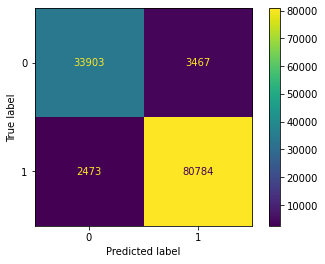

In [ ]:
cm = confusion_matrix(y_test, y_pred_fair)
tn, fp, fn, tp = cm.ravel()
plot_confusion_matrix(search, X_test_fair, y_test) 

In [ ]:
print(search.best_score_)

0.9463902508349321


In [ ]:
X_train_fair = X_train.drop(columns=['driver_race','driver_gender','officer_id'],axis=1)
X_test_fair = X_test.drop(columns=['driver_race','driver_gender','officer_id'], axis=1)

In [ ]:
search.fit(X_train_fair,y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [5, 10, 15]}, return_train_score=True,
             scoring='accuracy')

In [ ]:
y_pred_fair = search.best_estimator_.predict(X_test_fair)

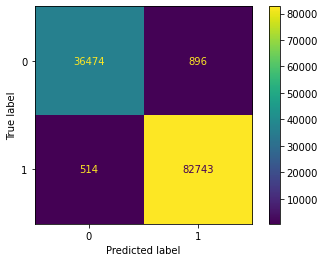

In [ ]:
cm = confusion_matrix(y_test, y_pred_fair)
tn_, fp_, fn_, tp_ = cm.ravel()
plot_confusion_matrix(search, X_test_fair, y_test) 

In [ ]:
print(search.best_score_)

0.986527392879983


In [ ]:
sep_ = separation(tn_,fp_,fn_,tp_)
suf_ = sufficiency(tn_, fp_, fn_, tp_)
ind_ = independence (tp_,tn_,fn_,fp_ )

In [ ]:
print (sep_)
print(suf_)
print(ind_)

(0.9892872942048566, 0.9861036011679464)
(0.9938263449319577, 0.023976451699223977)
0.6933688146103277
